In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import glob 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

In [2]:
#Functions definitions

def read_images():
    test_image_names = glob.glob('./test_images/*.jpg')
    test_images = []
    for test_image_name in test_image_names:
        image = plt.imread(test_image_name)
        test_images.append(image)
    return test_images
images = read_images()

#PARAMS
img_size = (images[0].shape[1], images[0].shape[0])
abs_sobel_orient = 'x'
abs_sobel_kernel = 15
abs_sobel_threshold = (24,100)
mag_sobel_kernel = 15
mag_sobel_threshold = (20,100)
dir_sobel_kernel = 31
dir_sobel_threshold = (0, np.pi/2)
rgb_thresh_channel = 'r'
rgb_thresh_threshold = (130,255)
hls_thresh_channel = 's'
hls_thresh_threshold = (110,255)
hsv_thresh_channel = 'h'
hsv_thresh_threshold = (0,110)
YCrCb_thresh_channel = 'Y'
YCrCb_thresh_threshold = (110,250)
src = np.float32([(257, 685), (1050, 685), (583, 460),(702, 460)])
dst = np.float32([(200, 720), (1080, 720), (200, 0), (1080, 0)])
M = cv2.getPerspectiveTransform(src, dst) 
Minv = cv2.getPerspectiveTransform(dst, src)

nx, ny = 9, 6
channels = 3

#calibration image list
image_names = glob.glob('./camera_cal/calibration*.jpg')

#imgpoints and objpoints
imgpoints = [] #2D in image plane
objpoints = [] #3D in real life, all same
objp = np.zeros((ny * nx, channels), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) #x, y coordinates


#loop through
for idx, image_name in enumerate(image_names):
    cal_img = mpimg.imread(image_name)
    cal_img_gray = cv2.cvtColor(cal_img,cv2.COLOR_BGR2GRAY)

    #get corners
    ret, corners = cv2.findChessboardCorners(cal_img_gray, (nx, ny), None)

    #add to object and image points
    if ret == True:
        print("Corners for img", str(idx))
        imgpoints.append(corners)
        objpoints.append(objp)

        #draw and display corners
        cv2.drawChessboardCorners(cal_img, (nx, ny), corners, ret)
        write_path = "./camera_cal_corners/calibration" + str(idx) + "_corners.jpg"
        cv2.imwrite(write_path, cal_img)
        #print("Saved corners for image ", str(idx))


#load arbitrary image for size
img  = cv2.imread('./camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

#camera calibration coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

#save camera calibration results for later
calibration = {}
calibration['mtx'] = mtx
calibration['dist'] = dist
pickle.dump(calibration, open("./calibration.p", "wb"))


Corners for img 1
Corners for img 2
Corners for img 3
Corners for img 4
Corners for img 5
Corners for img 6
Corners for img 7
Corners for img 8
Corners for img 9
Corners for img 10
Corners for img 11
Corners for img 12
Corners for img 13
Corners for img 16
Corners for img 17
Corners for img 18
Corners for img 19


In [3]:


def undistort(image):
    calibration = pickle.load( open("calibration.p", "rb") )
    mtx = calibration['mtx']
    dist = calibration['dist']
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    return undist

def undistort_rect(image):
    img_size = (image.shape[1], image.shape[0])
    undistorted_drawn = cv2.rectangle(np.copy(image), pt1=(0,img_size[1]), pt2=(img_size[0],img_size[1]-100), color=(255,0,0), thickness=3)
    return undistorted_drawn

def abs_sobel_thresh(image, orient = 'x', sobel_kernel=3, thresh = (0.7,5)):
    gray = cv2. cvtColor(image, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0 ,ksize = sobel_kernel)
    if orient =='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1 ,ksize = sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    abs_sobel_thresh = np.zeros_like(scaled_sobel)
    abs_sobel_thresh[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1

    return abs_sobel_thresh

#Convert to grayscale, calculate magnitude, rescale and return binary output
def mag_thresh(image, sobel_kernel=3, thresh=(1, 5)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0 ,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1 ,ksize = sobel_kernel)

    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    scaled_magnitude = np.uint8(255*gradient_magnitude/np.max(gradient_magnitude))

    output = np.zeros_like(scaled_magnitude)
    output[(scaled_magnitude > thresh[0]) & (scaled_magnitude < thresh[1])] = 1

    return output

#Convert to grayscale, calculate x and y gradients and apply threshold
def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2. cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0 ,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1 ,ksize = sobel_kernel)

    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    absgraddir = np.arctan2(sobely, sobelx)

    output = np.zeros_like(absgraddir)
    output[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1

    return output

def rgb_thresh(image, channel="r", thresh=(0, 1)):
    if channel=="r":
        thrshld_channel = image[:,:,0]
    if channel=="g":
        thrshld_channel = image[:,:,1]
    if channel=="b":
        thrshld_channel = image[:,:,2]

    rgb_thrshld = np.zeros_like(thrshld_channel)
    rgb_thrshld[(thrshld_channel > thresh[0]) & (thrshld_channel < thresh[1])] = 1
    return rgb_thrshld

def hls_thresh(image, channel="h", thresh=(0, 50)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    if channel=="h":
        thrshld_channel = hls[:,:,0]
    if channel=="l":
        thrshld_channel = hls[:,:,1]
    if channel=="s":
        thrshld_channel = hls[:,:,2]

    hls_threshold = np.zeros_like(thrshld_channel)
    hls_threshold[(thrshld_channel > thresh[0]) & (thrshld_channel < thresh[1])] = 1
    return hls_threshold

def hsv_thresh(image, channel="h", thresh=(0, 50)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    if channel=="h":
        thrshld_channel = hsv[:,:,0]
    if channel=="s":
        thrshld_channel = hsv[:,:,1]
    if channel=="v":
        thrshld_channel = hsv[:,:,2]

    hsv_threshold = np.zeros_like(thrshld_channel)
    hsv_threshold[(thrshld_channel > thresh[0]) & (thrshld_channel < thresh[1])] = 1
    return hsv_threshold

def YCrCb_thresh(image, channel="Y", thresh=(0, 50)):
    YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    if channel=="Y":
        thrshld_channel = YCrCb[:,:,0]
    if channel=="Cr":
        thrshld_channel = YCrCb[:,:,1]
    if channel=="Cb":
        thrshld_channel = YCrCb[:,:,2]

    YCrCb_threshold = np.zeros_like(thrshld_channel)
    YCrCb_threshold[(thrshld_channel > thresh[0]) & (thrshld_channel < thresh[1])] = 1
    return YCrCb_threshold

def combine_threshs(hls_thresh_1, abs_sobel_thresh_1):
    combined = np.zeros_like(hls_thresh_1)
    combined[hls_thresh_1 == 1] = 1
    combined[abs_sobel_thresh_1 == 1] = 1
    return combined

def filter(image):
    height, width = image.shape[0], image.shape[1]
    bl = (width / 2 - 480, height - 30)
    br = (width / 2 + 480, height - 30)
    tl = (width / 2 - 60, height / 2 + 76)
    tr = (width / 2 + 60, height / 2 + 76)

    fit_left = np.polyfit((bl[0], tl[0]), (bl[1], tl[1]), 1)
    fit_right = np.polyfit((br[0], tr[0]), (br[1], tr[1]), 1)
    fit_bottom = np.polyfit((bl[0], br[0]), (bl[1], br[1]), 1)
    fit_top = np.polyfit((tl[0], tr[0]), (tl[1], tr[1]), 1)

    # Find the region inside the lines
    x, y = np.meshgrid(np.arange(0, image.shape[1]), np.arange(0, image.shape[0]))
    mask = (y > (x * fit_left[0] + fit_left[1])) & \
           (y > (x * fit_right[0] + fit_right[1])) & \
           (y > (x * fit_top[0] + fit_top[1])) & \
           (y < (x * fit_bottom[0] + fit_bottom[1]))
    
    image_window = np.copy(image)
    image_window[mask == False] = 0

    return image_window

def transform_image(windowed_image, M, img_size):
    return cv2.warpPerspective(windowed_image, M, img_size)

def get_hist(img):
    hist = np.sum(img[int(img.shape[0]//2):,:], axis=0)
    #hist = np.sum(img[img.shape[0]/2:,:], axis=0)
    return hist

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def find_lanes(persp):
    #create historgram for bottom half of persp
    hist = np.sum(persp[int(persp.shape[0]/2):,:], axis=0) 
    #output image to draw on + visualize
    out_img = np.dstack((persp, persp, persp))*255
    #peaks of left + right halves if hist	
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    #number of sliding windows
    nwindows = 9
    #window height 
    window_height = np.int(persp.shape[0]/nwindows)

    #x and y positions of all nonzero pizels in img
    nonzero = persp.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #current positions to be updated
    leftx_current = leftx_base
    rightx_current = rightx_base

    #width of windows +/- margin
    margin = 100
    #min number of pixels to recenter window
    minpix = 50

    #empty lists to receive left and right lane pixel indices
    left_lane_indices = []
    right_lane_indices = []

    #go through windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = persp.shape[0] - (window+1)*window_height
        win_y_high = persp.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_indices = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_indices = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_indices) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_indices]))
        if len(good_right_indices) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_indices]))

    # Concatenate the arrays of indices
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_indices]
    lefty = nonzeroy[left_lane_indices] 
    rightx = nonzerox[right_lane_indices]
    righty = nonzeroy[right_lane_indices] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, persp.shape[0]-1, persp.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_indices], nonzerox[left_lane_indices]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_indices], nonzerox[right_lane_indices]] = [0, 0, 255]
    
    return out_img, ploty, left_fit, left_fitx, leftx_base, right_fit, right_fitx, rightx_base

def Lcurvature_radius(persp, left_fit):
    y_eval = np.max(persp[0])
    left_curverad = (((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0]))/1000
    Lcurvature_string = 'Left Curvature: {:.2f}Km'.format(left_curverad)
    return Lcurvature_string

def Rcurvature_radius(persp, right_fit):
    y_eval = np.max(persp[0])
    right_curverad = (((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0]))/1000
    Rcurvature_string = 'Right Curvature: {:.2f}Km'.format(right_curverad)
    return Rcurvature_string

def pos_from_center(persp, leftx_base, rightx_base):
    pos = persp.shape[1]
    offset = (((leftx_base + rightx_base)/2.0-pos/2)*xm_per_pix)
    location_string = 'Center offset: {:.2f}m'.format(offset)
    return location_string

def final_img(image, persp_transform_image, ploty, leftx_base, left_fit, left_fitx, rightx_base, right_fit, right_fitx, Minv):
    #perspective transform back
    warp_zero = np.zeros_like(persp_transform_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (persp_transform_image.shape[1], persp_transform_image.shape[0])) 

    #Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    #info strings
    Rcurvature_string = Rcurvature_radius(persp_transform_image, right_fit)
    Lcurvature_string = Lcurvature_radius(persp_transform_image, left_fit)
    location_string = pos_from_center(persp_transform_image, leftx_base, rightx_base)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,Lcurvature_string,(100,50), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,Rcurvature_string,(100,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,location_string,(100,150), font, 2,(255,255,255),2,cv2.LINE_AA)
    return result

def process_frame(image):
    #undistorting
    undistorted_image = undistort(image)

    #binary thresholding
    hls_thresh_image = hls_thresh(undistorted_image, channel=hls_thresh_channel, thresh=hls_thresh_threshold)
    abs_sobel_thresh_image = abs_sobel_thresh(undistorted_image, orient=abs_sobel_orient, sobel_kernel = abs_sobel_kernel, thresh= abs_sobel_threshold)
    combined_image = combine_threshs(hls_thresh_image, abs_sobel_thresh_image)
    windowed_image = filter(combined_image)

    #perspective transform
    persp_transform_image = transform_image(windowed_image, M, img_size)

    #lanes
    out_img, ploty, left_fit, left_fitx, leftx_base, right_fit, right_fitx, rightx_base = find_lanes(persp_transform_image)

    #final image
    result = final_img(image, persp_transform_image, ploty, leftx_base, left_fit, left_fitx, rightx_base, right_fit, right_fitx, Minv)
    
    #plotting
    #plt.imshow(result)
    #plt.savefig('test_image_8_annotated')

    return result

def make_video(input_path, output_path):
    input_file = VideoFileClip(input_path)
    output_clip = input_file.fl_image(process_frame)
    output_clip.write_videofile(output_path, audio=False)


Undistortion


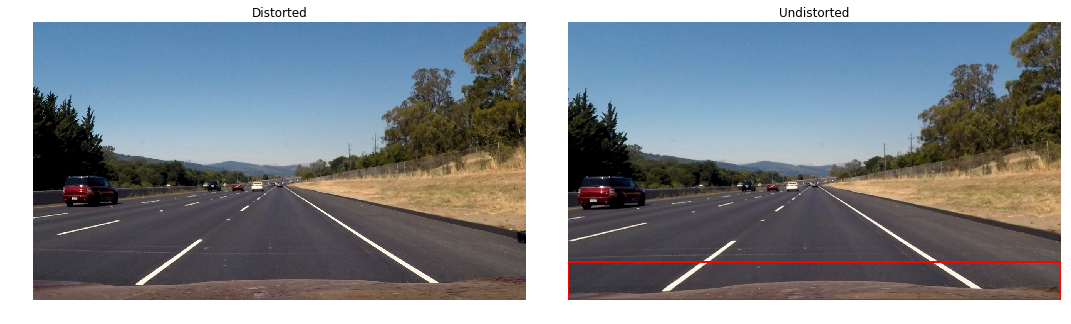

==== Binary threshold images ====


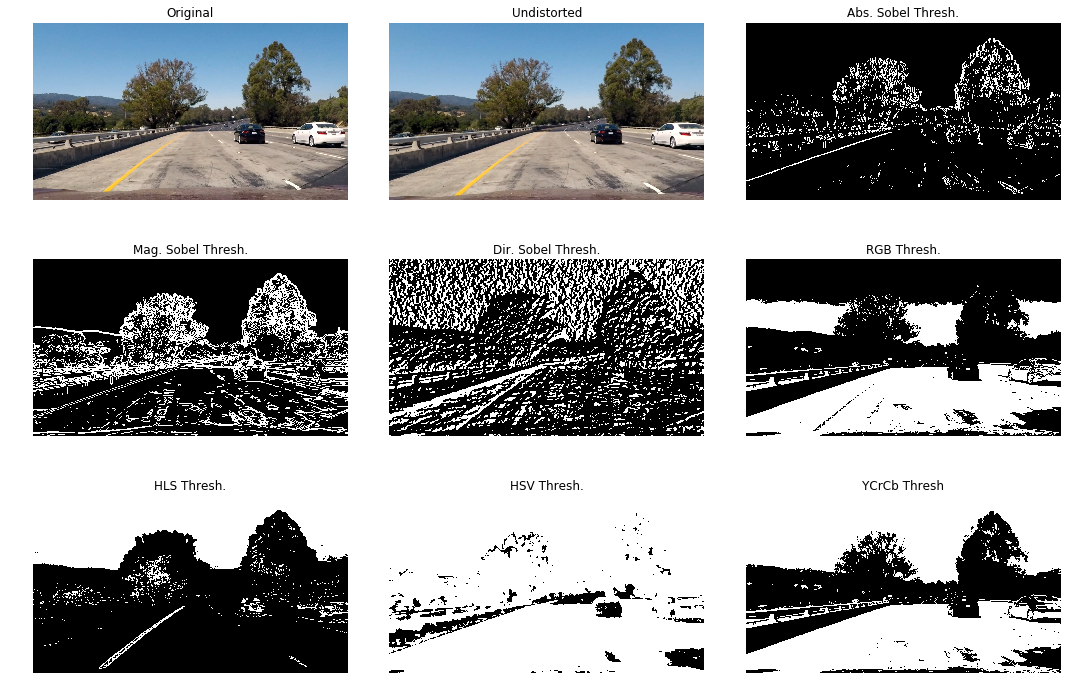

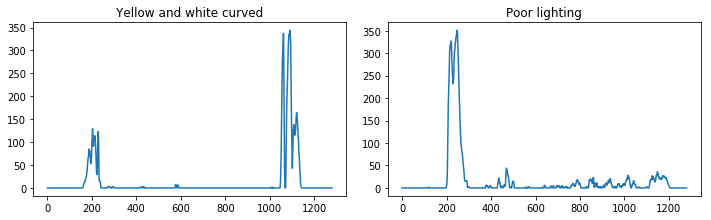

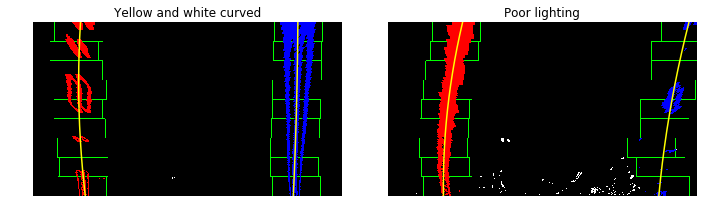

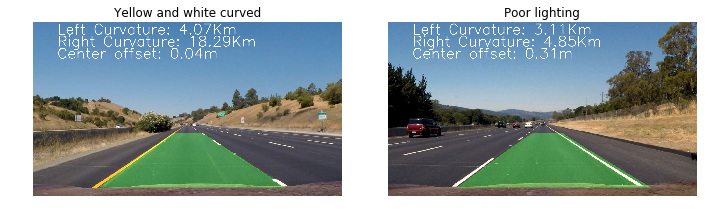

In [4]:
images = read_images()

#PARAMS
img_size = (images[0].shape[1], images[0].shape[0])
abs_sobel_orient = 'x'
abs_sobel_kernel = 15
abs_sobel_threshold = (24,100)
mag_sobel_kernel = 15
mag_sobel_threshold = (20,100)
dir_sobel_kernel = 31
dir_sobel_threshold = (0, np.pi/2)
rgb_thresh_channel = 'r'
rgb_thresh_threshold = (130,255)
hls_thresh_channel = 's'
hls_thresh_threshold = (110,255)
hsv_thresh_channel = 'h'
hsv_thresh_threshold = (0,110)
YCrCb_thresh_channel = 'Y'
YCrCb_thresh_threshold = (110,250)
src = np.float32([(257, 685), (1050, 685), (583, 460),(702, 460)])
dst = np.float32([(200, 720), (1080, 720), (200, 0), (1080, 0)])
M = cv2.getPerspectiveTransform(src, dst) 
Minv = cv2.getPerspectiveTransform(dst, src)


#IMAGE TRANSFORMATIONS
undistorted_images = [undistort(image) for image in images]
undistorted_drawn_images = [undistort_rect(undistorted_image) for undistorted_image in undistorted_images]
abs_sobel_thresh_images = [abs_sobel_thresh(undistorted_image, orient=abs_sobel_orient, sobel_kernel = abs_sobel_kernel, thresh= abs_sobel_threshold) for undistorted_image in undistorted_images]
mag_thresh_images = [mag_thresh(undistorted_image, sobel_kernel = mag_sobel_kernel, thresh= mag_sobel_threshold) for undistorted_image in undistorted_images]
dir_thresh_images = [dir_thresh(undistorted_image, sobel_kernel = dir_sobel_kernel, thresh= dir_sobel_threshold) for undistorted_image in undistorted_images]
rgb_thresh_images = [rgb_thresh(undistorted_image, channel=rgb_thresh_channel, thresh=rgb_thresh_threshold) for undistorted_image in undistorted_images]
hls_thresh_images = [hls_thresh(undistorted_image, channel=hls_thresh_channel, thresh=hls_thresh_threshold) for undistorted_image in undistorted_images]
hsv_thresh_images = [hsv_thresh(undistorted_image, channel=hsv_thresh_channel, thresh=hsv_thresh_threshold) for undistorted_image in undistorted_images]
YCrCb_images = [YCrCb_thresh(undistorted_image, channel=YCrCb_thresh_channel, thresh=YCrCb_thresh_threshold) for undistorted_image in undistorted_images]
combined_images = [combine_threshs(hls_thresh, abs_sobel_thresh) for hls_thresh, abs_sobel_thresh in zip(hls_thresh_images, abs_sobel_thresh_images)]
windowed_images = [filter(combined) for combined in combined_images]
birds_view_images = [transform_image(windowed_image, M, img_size) for windowed_image in windowed_images]
histogram_images = [get_hist(birds_view_image) for birds_view_image in birds_view_images]
progress = [images, undistorted_images, abs_sobel_thresh_images, mag_thresh_images, dir_thresh_images, rgb_thresh_images, hls_thresh_images, hsv_thresh_images, YCrCb_images]


#PLOT CALIBRATION
def plot_calibration():
    distorted = images[1]
    undistorted_drawn = undistorted_drawn_images[1]
    labels = ['Distorted', 'Undistorted']
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,4.5))
    fig.tight_layout()
    ax1.imshow(distorted)
    ax1.set_title(labels[0])
    ax1.axis('off')
    ax2.imshow(undistorted_drawn)
    ax2.set_title(labels[1])
    ax2.axis('off')
    plt.show()
    plt.savefig('image.png', bbox_inches='tight', cmap='gray')
print("Undistortion")
plot_calibration()


#PLOT PROGRESS
def plot_progress(progress, img):
    labels = ['Original', 'Undistorted', 'Abs. Sobel Thresh.', 'Mag. Sobel Thresh.', 'Dir. Sobel Thresh.', 'RGB Thresh.', 'HLS Thresh.', 'HSV Thresh.', 'YCrCb Thresh']
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15,10))
    axes = axes.ravel()
    fig.tight_layout()

    for ax, transformation, label in zip(axes, progress, labels):
        ax.imshow(transformation[img], cmap='gray')
        ax.set_title(label)
        ax.axis('off')
    plt.show()
    plt.savefig('image.png', bbox_inches='tight', cmap='gray')
print("==== Binary threshold images ====")
plot_progress(progress, 2)


#PLOT ALL
def plot_all(images = [], birds_view_images = [], option = 'transformation'):
    labels = ["Yellow and white", "Yellow and white curved", "Poor lighting", "Straight white", "Yellow and white curved 2", "Very poor lighting 1", "Very poor lighting 2", "Very poor lighting 3"]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,3))
    axes = axes.ravel()
    fig.tight_layout()

    if option == 'transformation':
        for ax, image, label in zip(axes, images[1:3], labels[1:3]):
            ax.imshow(image, cmap='gray')
            ax.set_title(label)
            ax.axis('off')

    if option == 'histogram':
        for ax, image, label in zip(axes, images[1:3], labels[1:3]):
            ax.plot(image)
            ax.set_title(label)

    elif option == 'lanes':
        for ax, birds_view_image, label in zip(axes, birds_view_images[1:3], labels[1:3]):
            out_img, ploty, left_fit, left_fitx, leftx_base, right_fit, right_fitx, rightx_base = find_lanes(birds_view_image)
            ax.imshow(out_img)
            ax.set_title(label)
            ax.plot(left_fitx, ploty, color='yellow')
            ax.plot(right_fitx, ploty, color='yellow')
            ax.axis('off')

    elif option == 'final':
        for ax, image, birds_view_image,label in zip(axes, images, birds_view_images[1:3], labels[1:3]):
            out_img, ploty, left_fit, left_fitx, leftx_base, right_fit, right_fitx, rightx_base = find_lanes(birds_view_image)
            result = final_img(image, birds_view_image, ploty, leftx_base, left_fit, left_fitx, rightx_base, right_fit, right_fitx, Minv)
            ax.imshow(result)
            ax.set_title(label)
            ax.axis('off')
    plt.show()

plot_all(images = histogram_images, option = 'histogram') #plot transformations
#plot_all(images = images, birds_view_images = birds_view_images, option = 'transformation') #plot lane lines images
plot_all(images = images, birds_view_images = birds_view_images, option = 'lanes') #plot lane lines images
plot_all(images = images, birds_view_images = birds_view_images, option = 'final') #plot final images


In [5]:
make_video('project_video.mp4', 'project_video_OUTPUT.mp4')

[MoviePy] >>>> Building video project_video_OUTPUT.mp4
[MoviePy] Writing video project_video_OUTPUT.mp4


100%|█████████▉| 1260/1261 [06:29<00:00,  2.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_OUTPUT.mp4 



In [6]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_OUTPUT.mp4'))